# Bandit Examples

+ Based on Lecture 13

### Packages

In [1]:
%matplotlib inline
# data and plotting packages
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
np.random.seed(42)

# bandit components
from bandits.bandits import FixedBandit, BernoulliBandit, NormalBandit
from bandits.games import BanditGame, EpsilonGreedy, UCBBayesian, ThompsonBayesian
from bandits.experiments import Experiment

### Create and test bandits

We generate three types of bandits and print their rewards.  
Notice that besides construction, we only use methods of the base class Bandit

In [2]:
fixed_bandit = FixedBandit(rewards=[1.2, 0.2, 1.1, 0.4])
bern_bandit = BernoulliBandit(probs=[0.3, 0.6, 0.5, 0.8])
norm_bandit = NormalBandit(means=[1.0, 0.5, 1.5, 0.0], stdevs=[1.0, 2.0, 1.5, 1.0])

bdf = pd.DataFrame(
    data={'Type': ['Fixed', 'Bernouli', 'Normal'],
          'NumActions': [fixed_bandit.n_actions, bern_bandit.n_actions, norm_bandit.n_actions],
          'BestAction': [fixed_bandit.best_action, bern_bandit.best_action, norm_bandit.best_action],
          'BestReward': [fixed_bandit.best_reward, bern_bandit.best_reward, norm_bandit.best_reward]})

display(bdf)

,Type,NumActions,BestAction,BestReward
0,Fixed,4,0,1.2
1,Bernouli,4,3,0.8
2,Normal,4,2,1.5


In [3]:
# pull each lever once in sequence and print the rewards
print('Rewards from each lever in sequence')
print('Fixed: {}'.format([fixed_bandit.get_reward(i) for i in range(fixed_bandit.n_actions)]))
print('Bernoulli: {}'.format([bern_bandit.get_reward(i) for i in range(bern_bandit.n_actions)]))
print('Normal: {}'.format([round(norm_bandit.get_reward(i), 4) for i in range(norm_bandit.n_actions)]))

Rewards from each lever in sequence
Fixed: [1.2, 0.2, 1.1, 0.4]
Bernoulli: [0, 0, 0, 1]
Normal: [0.7658, 0.0317, 3.8688, 0.7674]


### Games

The utility function run_game below creates a Bernoulli bandit of K arms and runs an episode of T turns.  
Three games are set-up with $\epsilon$-greedy 10%, Bayesian UCB and Thomson sampling policies.

In [4]:
def run_games(K, T, verbose=True):
    """
    Run three games for T time steps using a randomly initialized K-armed bandit.
    The games use EpsilonGreedySA, BayesUCB and Thompson policies

    Args:
        K (int): number of bandit arms.
        T (int): number of time steps to play
        verbose: flag to print summary
    Returns:
        dictionary of games
    """
    probs = np.random.random(K)
    b = BernoulliBandit(probs)

    games = {'EpsGreedy': EpsilonGreedy(b, 0.1),
             'BayesUCB': UCBBayesian(b),
             'Thompson': ThompsonBayesian(b)
            }

    if verbose:
        print ("Randomly generated {}-armed Bernoulli bandit with reward probabilities:\n  {}"
               .format(K, np.round(b.probs, 4)))
        print ("The best arm has index={} and probability={}\n".format(
            max(range(K), key=lambda i: b.probs[i]), np.round(max(b.probs), 4)))
        print("Running each game for {} steps".format(T))
        
    for nam, gam in games.items():
        gam.run(T)
        if verbose:
            print("{}".format(nam))
            print("  Cumulative reward per step {}".format(np.round(gam.cumreward / T, 3)))
            print("  Cumulative regret per step {}".format(np.round(gam.cumregret / T, 3)))
    return(games)

In [5]:
games_dict = run_games(K=10, T=100, verbose=0)

### Plot the time series of regrets per step

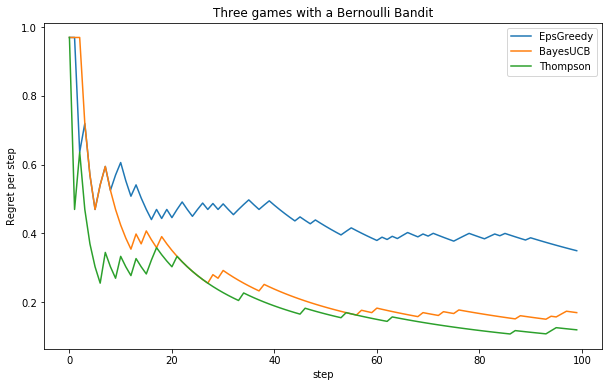

In [6]:
nsteps = len(games_dict[list(games_dict.keys())[0]].regrets)
rdf = pd.DataFrame.from_dict({'step': range(nsteps)})
for nam, gam in games_dict.items():
    nsteps = len(gam.regrets)
    x = range(nsteps)
    y = np.cumsum(gam.regrets) / np.arange(1, nsteps + 1)
    tmp = pd.DataFrame.from_dict({'step': x, nam: y})
    rdf = pd.merge(rdf, tmp, on=['step'])

#print(df)

fig = plt.figure(figsize=(10,6))
ax = fig.add_subplot(111)
rdf.plot(x='step', ax=ax, title='Three games with a Bernoulli Bandit');\
ax.set_ylabel('Regret per step');

### Experiments  

The utility function run_expriment below creates a Bernoulli bandit of K arms and runs an episode of T turns for N runs. It returns statistics 

In [7]:
def run_experiment(K, T, N, verbose=True):
    """
    Run K-armed Bernouli bandit games for T time steps.
    Repeat for N runs and collect reward and regret statistics per game and step.
    Use the same bandit for each run and start each run with the same prior
    
    Args:
        K (int): number of bandit arms.
        T (int): number of time steps to play
        N (int): number of runs
    Returns: the experiment object
    """

    probs = np.random.random(K)
    b = BernoulliBandit(probs)
    games = {'EpsGreedy': EpsilonGreedy(b, 0.1),
         'BayesUCB': UCBBayesian(b),
         'Thompson': ThompsonBayesian(b)
        }

    if verbose:
        print ("Randomly generated {}-armed Bernoulli bandit with reward probabilities:\n  {}"
               .format(K, np.round(b.probs, 4)))
        print ("The best arm has index={} and probability={}\n".format(
            max(range(K), key=lambda i: b.probs[i]), np.round(max(b.probs), 4)))

    ex = Experiment(games)
    if verbose:
        print("Running an experiment with {} games for {} steps and {} runs".format(len(games), T, N))
    ex.run(T, N, verbose=verbose)
    return(ex)

In [8]:
expt = run_experiment(K=10, T=500, N=100, verbose=True)

Randomly generated 10-armed Bernoulli bandit with reward probabilities:
  [0.4929 0.1462 0.679  0.7938 0.8573 0.5428 0.3785 0.642  0.2056 0.1732]
The best arm has index=4 and probability=0.8573

Running an experiment with 3 games for 500 steps and 100 runs
==> EpsGreedy for 500 steps and 100 runs. MeanRewardPerStep=0.7743. StdevRewardPerStep=0.0446
==> BayesUCB for 500 steps and 100 runs. MeanRewardPerStep=0.8187. StdevRewardPerStep=0.0499
==> Thompson for 500 steps and 100 runs. MeanRewardPerStep=0.7938. StdevRewardPerStep=0.0247
